In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import uniform
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn import under_sampling, over_sampling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from xgboost import XGBClassifier
import statsmodels.api as sm
import shap

## Load Data

In [2]:
df = pd.read_csv('../data/data_modeling.csv',sep=',')
df.head(2)

,age,default,balance,housing,loan,duration,campaign,previous,y,contact_group,...,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,4.350000,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,2.516667,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1


In [3]:
y = df['y'].values
X = df.drop(labels = ['y'], axis = 1)
print("Shape of X is {} and that of y is {}".format(X.shape, y.shape))

Shape of X is (45206, 25) and that of y is (45206,)


## Class Imbalance (SMOTE)

In [4]:
X_sm, y_sm = over_sampling.SMOTE(0.5).fit_resample(X, y)
print("Shape of X is {} and that of y is {}".format(X_sm.shape, y_sm.shape))

Shape of X is (59878, 25) and that of y is (59878,)


## Split Train-Test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.3, random_state = 42)

In [6]:
df_test = X_test.copy()
df_test['y'] = y_test
df_test.to_csv("../data/data_test.csv", index = False)

Add constraint for Logistic Regression using statsmodel

In [7]:
X_train_stat = sm.add_constant(X_train)
X_test_stat = sm.add_constant(X_test)

## Modeling

In [8]:
def eval_classification(model, xtrain, ytrain, xtest, ytest):
    ypred = model.predict(xtest)
    ypred = (ypred > 0.5).astype(int)
    y_train = model.predict(xtrain)
    y_train = (y_train > 0.5).astype(int)
    
    return accuracy_score(ytest, ypred), precision_score(ytest, ypred), recall_score(ytest, ypred), roc_auc_score(ytest, ypred), f1_score(ytest, ypred), f1_score(ytrain, y_train)

def show_best_hyperparameter(model, hyperparameters):
    for key, value in hyperparameters.items() :
        print('Best '+key+':', model.get_params()[key])

### Model Selection

In [9]:
models = {
    "KNN" : KNeighborsClassifier(),
    "AdaBoost" :AdaBoostClassifier(random_state=42),
    "XGBoost" : XGBClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest" : RandomForestClassifier(random_state=42),
    "Logistic Regression Statsmodel" : sm.Logit(y_train,X_train_stat),
    "Logistic Regression" : LogisticRegression(random_state=42)
    }

In [10]:
scores = []
for model in models:
  print("Model "+model + " score:")
  classifier = models[model]
  if model!="Logistic Regression Statsmodel" :
    classifier.fit(X_train, y_train)
    score = eval_classification(classifier,X_train,y_train,X_test,y_test)
  else:
    result = classifier.fit_regularized(random_state = 42)
    score = eval_classification(result, X_train_stat, y_train, X_test_stat, y_test)

  scores.append([model,score[0],score[1], score[2], score[3], score[4], score[5]])

  print("Accuracy (Test Set): %.2f" % score[0])
  print("Precision (Test Set): %.2f" % score[1])
  print("Recall (Test Set): %.2f" % score[2])
  print("AUC (Test Set) : %.2f" % score[3])
  print("F1-Score (Test Set): %.2f" % score[4])
  print("F1-Score (Train Set): %.2f" % score[5])
  print()

Model KNN score:
Accuracy (Test Set): 0.85
Precision (Test Set): 0.74
Recall (Test Set): 0.84
AUC (Test Set) : 0.85
F1-Score (Test Set): 0.79
F1-Score (Train Set): 0.86

Model AdaBoost score:
Accuracy (Test Set): 0.90
Precision (Test Set): 0.89
Recall (Test Set): 0.82
AUC (Test Set) : 0.88
F1-Score (Test Set): 0.85
F1-Score (Train Set): 0.85

Model XGBoost score:
[17:07:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy (Test Set): 0.91
Precision (Test Set): 0.90
Recall (Test Set): 0.84
AUC (Test Set) : 0.89
F1-Score (Test Set): 0.87
F1-Score (Train Set): 0.92

Model Decision Tree score:
Accuracy (Test Set): 0.88
Precision (Test Set): 0.81
Recall (Test Set): 0.82
AUC (Test Set) : 0.86
F1-Score (Test Set): 0.82
F1-Score (Train Set): 1.00

Model Random Forest score:
Accuracy (Test Set): 0

Evaluation metric used in this model is F1, because the dataset has an imbalance target and we want to focuses on predicted positive label correctly. Recall is also used as a supporting metric because in this case we are trying to reduce the number of false negatives.

In [11]:
eval = pd.DataFrame(scores)
eval = eval.rename({0:'Model', 1: 'Accuracy', 2: 'Precision', 3: 'Recall', 4: 'AUC', 5: 'F1(test)', 6: 'F1(train)'}, axis = 1)
eval.sort_values(['F1(test)','Recall','F1(train)'], ascending=False).reset_index().drop('index', axis = 1)

,Model,Accuracy,Precision,Recall,AUC,F1(test),F1(train)
0,Random Forest,0.914217,0.894306,0.841453,0.895958,0.867075,0.999928
1,XGBoost,0.913995,0.897772,0.836598,0.894573,0.866106,0.920843
2,Logistic Regression Statsmodel,0.910766,0.924107,0.797087,0.882240,0.855910,0.862009
3,AdaBoost,0.904531,0.885270,0.819019,0.883073,0.850857,0.849853
4,Decision Tree,0.877032,0.812003,0.820023,0.862726,0.815993,1.000000
5,Logistic Regression,0.866845,0.835614,0.746359,0.836610,0.788468,0.797143
6,KNN,0.849588,0.740975,0.841955,0.847673,0.788245,0.861232


Based on metrics evaluation, Random Forest has the highest F1 and Recall score, thus, we take Random Forest to be used in our model. But, Random Forest has an indication of overfitting based on the test score and the train score, so we have to tuned the hyperparameter of it to make the model more robust.

### Hyperparameter Tuning

In [12]:
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1800, num = 23)],
                       bootstrap = [True],
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(1, 110, num = 25)], 
                       min_samples_split = [5, 10, 15, 20, 25],
                       min_samples_leaf = [1, 3, 5, 7, 9],
                       max_features = ['auto', 'sqrt', 'log2'], 
                       n_jobs = [-1],
                      )

rf = RandomForestClassifier(random_state=42)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=7, random_state=42)
rf_tuned.fit(X_train,y_train)

score = eval_classification(rf_tuned,X_train,y_train,X_test,y_test)
print("Accuracy (Test Set): ", score[0])
print("Precision (Test Set): ", score[1])
print("Recall (Test Set): ", score[2])
print("AUC (Test Set) : ", score[3])
print("F1-Score (Test Set): ", score[4])
print("F1-Score (Train Set): ", score[5])

Accuracy (Test Set):  0.911767980405255
Precision (Test Set):  0.894746311622886
Recall (Test Set):  0.8325799430771806
AUC (Test Set) :  0.8918966765673619
F1-Score (Test Set):  0.8625444454080307
F1-Score (Train Set):  0.9130676140779393


In [13]:
show_best_hyperparameter(rf_tuned.best_estimator_, hyperparameters)

Best n_estimators: 1413
Best bootstrap: True
Best criterion: gini
Best max_depth: 41
Best min_samples_split: 10
Best min_samples_leaf: 5
Best max_features: auto
Best n_jobs: -1


After getting the best hyperparameter, the model is retrained using those hyperparameters and we can evaluate the prediction of data test from new model.

In [14]:
rf_new = RandomForestClassifier(n_estimators=100, bootstrap=True, criterion='entropy', max_depth=100, min_samples_split=15, min_samples_leaf=3, random_state=42, max_features='log2', n_jobs=-1)
rf_new.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=100, max_features='log2',
                       min_samples_leaf=3, min_samples_split=15, n_jobs=-1,
                       random_state=42)

In [15]:
score = eval_classification(rf_new,X_train,y_train,X_test,y_test)
print("Accuracy (Test Set): ", score[0])
print("Precision (Test Set): ", score[1])
print("Recall (Test Set): ", score[2])
print("AUC (Test Set) : ", score[3])
print("F1-Score (Test Set): ", score[4])
print("F1-Score (Train Set): ", score[5])

Accuracy (Test Set):  0.9135493208639501
Precision (Test Set):  0.9028436018957346
Recall (Test Set):  0.8292315419387243
AUC (Test Set) :  0.8923907688844651
F1-Score (Test Set):  0.864473339732961
F1-Score (Train Set):  0.9161654414494692


In [16]:
print(classification_report(y_test, rf_new.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     11991
           1       0.90      0.83      0.86      5973

    accuracy                           0.91     17964
   macro avg       0.91      0.89      0.90     17964
weighted avg       0.91      0.91      0.91     17964



# Insight from Model

Insight can be found from the model that has been built which later will be the basis for determining business recommendations and answering the objectives of this project.

In [17]:
print(confusion_matrix(y_test, rf_new.predict(X_test)))

[[11458   533]
 [ 1020  4953]]


In [18]:
X_test.describe()['duration']

count    17964.000000
mean         5.354686
std          5.029276
min          0.000000
25%          2.083333
50%          3.739621
75%          6.933333
max         63.083333
Name: duration, dtype: float64

Model can predict correctly 16420 data out of 17964 from data test.

With SHAP value, model can be explained by how the importance and the impact of each feature to predict the target.

In [19]:
explainer = shap.TreeExplainer(rf_new)
shap_values = explainer.shap_values(X_train)

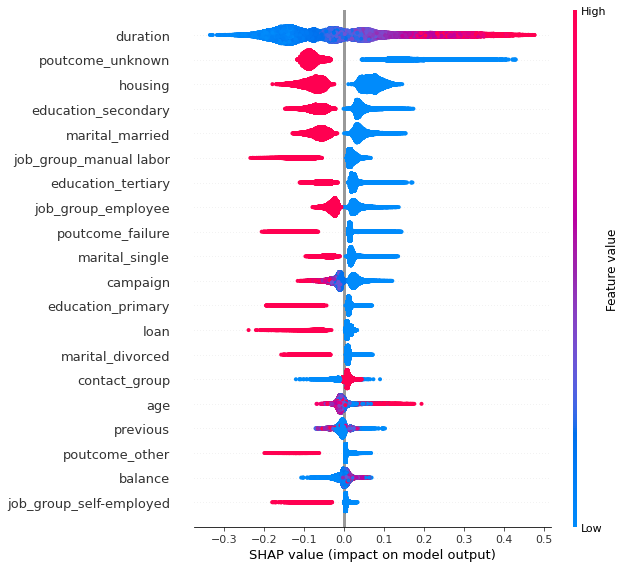

In [20]:
shap.summary_plot(shap_values[1], X_train)

In this plot, feature is ordered by the importance to the model. The x-values (impact on model) show whether the effect of that value is associated with a higher or lower prediction. Color shows whether that variable is high (in red) or low (in blue) for that observation.<br><br>
`duration` is the most important feature in this model, followed by `poutcome_unknown`, `housing`, `education_secondary`, and `marital_married` in the top five. It shows that these top 5 features have a high value to determine customers who tend to reject the campaign, except `duration`. But there are 2 more feature that have a high value of positive outcome which can be considered to sharpen the classification of customers towards positive values. Those features are, `contact_group`  and `balance`. The details of `duration` and `balance` can be shown in dependence plot.<br><br>
All types of `education` ('primary', 'secondary', 'tertiary') and `marital` ('single', 'married', 'divorced') appear to have the same value indicating the tendency of customers to not open a deposit account, so these features will be unlisted from the features selected for business recommendations. This is because the type of `education` and `marital` seems didn't have any difference in how they affect the target.

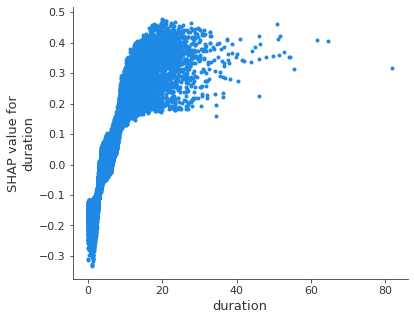

In [21]:
shap.dependence_plot('duration', shap_values[1], X_train, interaction_index=None)

Customers most likely will subscribe to the campaign if the duration of phone call is longer than 5 minutes.

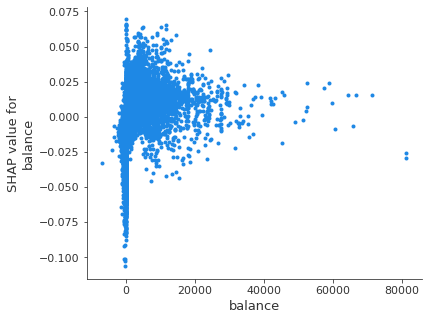

In [22]:
shap.dependence_plot('balance', shap_values[1], X_train, interaction_index=None)

Customers who have balance in their account (actually use this bank for saving and/or investing purpose) tend to subsribe to term deposit campaign.